In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import warnings

from ta.trend import SMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV 
from sklearn.utils.class_weight import compute_class_weight


In [32]:
df = pd.read_csv('./data/MSN.csv')

In [33]:
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,MSN,12/25/2017 9:15,73.1,73.1,73.1,73.1,4210,0
1,MSN,12/25/2017 9:16,73.0,73.0,73.0,73.0,5000,0
2,MSN,12/25/2017 9:18,73.5,73.5,73.5,73.5,210,0
3,MSN,12/25/2017 9:20,73.2,73.5,73.1,73.1,2050,0
4,MSN,12/25/2017 9:21,73.0,73.0,73.0,73.0,1380,0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         135354 non-null  object 
 1   Date/Time      135354 non-null  object 
 2   Open           135354 non-null  float64
 3   High           135354 non-null  float64
 4   Low            135354 non-null  float64
 5   Close          135354 non-null  float64
 6   Volume         135354 non-null  int64  
 7   Open Interest  135354 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 8.3+ MB


In [35]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], errors='coerce')
df.set_index('Date/Time', inplace=True)
df.sort_index(inplace=True)

In [36]:
df_resampled = df.resample('2min').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

In [37]:
df_resampled = df_resampled.dropna()

In [38]:
df_resampled = df_resampled[df_resampled['Volume'] > 0]

In [39]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78722 entries, 2017-12-25 09:14:00 to 2020-12-22 14:46:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    78722 non-null  float64
 1   High    78722 non-null  float64
 2   Low     78722 non-null  float64
 3   Close   78722 non-null  float64
 4   Volume  78722 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 3.6 MB


In [40]:
df_resampled['Next_2Min_Close'] = df_resampled['Close'].shift(-1)

In [41]:
df_resampled

,Open,High,Low,Close,Volume,Next_2Min_Close
Date/Time,,,,,,
2017-12-25 09:14:00,73.1,73.1,73.1,73.1,4210,73.0
2017-12-25 09:16:00,73.0,73.0,73.0,73.0,5000,73.5
2017-12-25 09:18:00,73.5,73.5,73.5,73.5,210,73.0
2017-12-25 09:20:00,73.2,73.5,73.0,73.0,3430,73.1
2017-12-25 09:22:00,73.0,73.1,73.0,73.1,2510,73.3
...,...,...,...,...,...,...
2020-12-22 14:20:00,82.8,82.8,82.7,82.8,1570,82.8
2020-12-22 14:22:00,82.8,82.8,82.8,82.8,1100,82.8
2020-12-22 14:24:00,82.7,82.8,82.7,82.8,4710,82.8


In [42]:
df_resampled['Target_Direction'] = (df_resampled['Next_2Min_Close'] > df_resampled['Close']).astype(int)

In [43]:
df_resampled

,Open,High,Low,Close,Volume,Next_2Min_Close,Target_Direction
Date/Time,,,,,,,
2017-12-25 09:14:00,73.1,73.1,73.1,73.1,4210,73.0,0
2017-12-25 09:16:00,73.0,73.0,73.0,73.0,5000,73.5,1
2017-12-25 09:18:00,73.5,73.5,73.5,73.5,210,73.0,0
2017-12-25 09:20:00,73.2,73.5,73.0,73.0,3430,73.1,1
2017-12-25 09:22:00,73.0,73.1,73.0,73.1,2510,73.3,1
...,...,...,...,...,...,...,...
2020-12-22 14:20:00,82.8,82.8,82.7,82.8,1570,82.8,0
2020-12-22 14:22:00,82.8,82.8,82.8,82.8,1100,82.8,0
2020-12-22 14:24:00,82.7,82.8,82.7,82.8,4710,82.8,0


                      Open      High       Low     Close    Volume  \
Open              1.000000  0.999919  0.999943  0.999913 -0.065219   
High              0.999919  1.000000  0.999866  0.999921 -0.064112   
Low               0.999943  0.999866  1.000000  0.999938 -0.065883   
Close             0.999913  0.999921  0.999938  1.000000 -0.065075   
Volume           -0.065219 -0.064112 -0.065883 -0.065075  1.000000   
Next_2Min_Close   0.999833  0.999832  0.999849  0.999869 -0.065409   
Target_Direction  0.007438  0.007800  0.006644  0.005953  0.026870   

                  Next_2Min_Close  Target_Direction  
Open                     0.999833          0.007438  
High                     0.999832          0.007800  
Low                      0.999849          0.006644  
Close                    0.999869          0.005953  
Volume                  -0.065409          0.026870  
Next_2Min_Close          1.000000          0.014611  
Target_Direction         0.014611          1.000000  


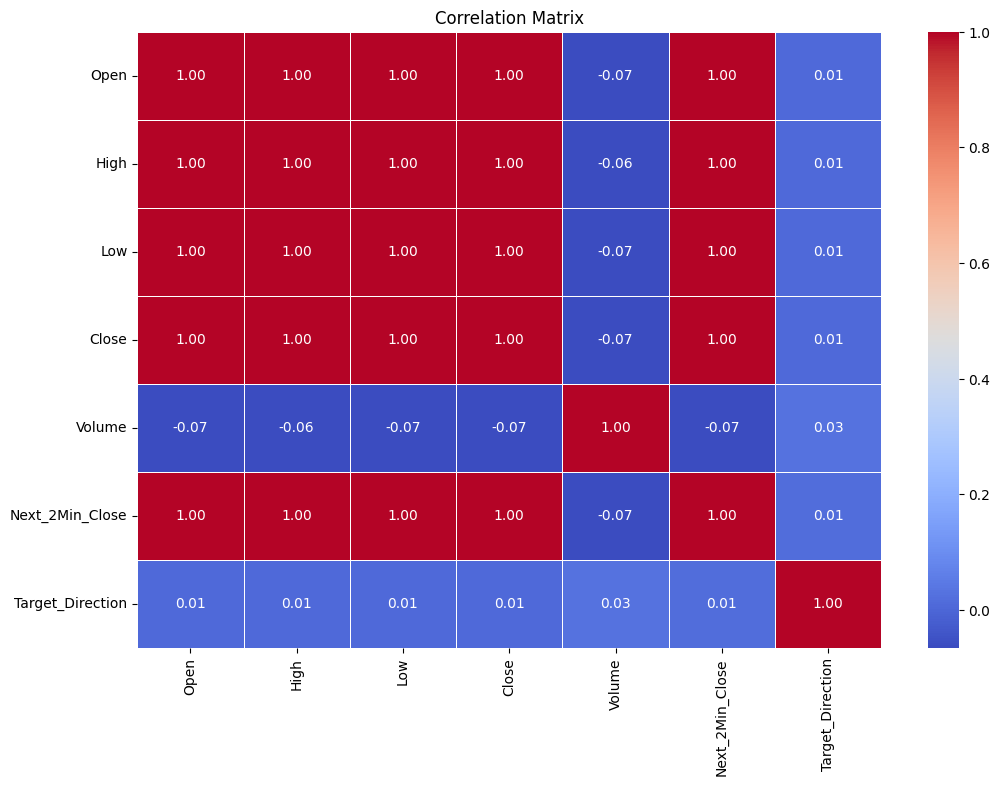

In [44]:
corr_matrix = df_resampled.corr(numeric_only=True)
print(corr_matrix)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


In [45]:
# 1. Lags (Giá đóng cửa N*2 phút trước)
for lag in [1, 2, 3, 5, 10]:
    df_resampled[f'Close_Lag_{lag}'] = df_resampled['Close'].shift(lag)

# 2. Percent Change (Phần trăm thay đổi so với N*2 phút trước)
for lag in [1, 2, 3, 5, 10]:
    df_resampled[f'Pct_Change_{lag}'] = df_resampled['Close'].pct_change(lag)

# 3. Dùng các thư viện TA
# Ý nghĩa window đã thay đổi: 10 = 10 * 2 phút = 20 phút
df_resampled['SMA_10'] = SMAIndicator(df_resampled['Close'], window=10).sma_indicator()
df_resampled['SMA_50'] = SMAIndicator(df_resampled['Close'], window=50).sma_indicator() # 50*2 = 100 phút
df_resampled['RSI_14'] = RSIIndicator(df_resampled['Close'], window=14).rsi()
df_resampled['ATR_14'] = AverageTrueRange(df_resampled['High'], df_resampled['Low'], df_resampled['Close'], window=14).average_true_range()
df_resampled['MACD_diff'] = MACD(df_resampled['Close'], window_slow=26, window_fast=12, window_sign=9).macd_diff()
df_resampled['BB_%B'] = BollingerBands(df_resampled['Close'], window=20).bollinger_pband()

# 4. Features về Volume
df_resampled['Volume_SMA_20'] = SMAIndicator(df_resampled['Volume'], window=20).sma_indicator()
df_resampled['Volume_Pct_Change'] = df_resampled['Volume'].pct_change(1)


In [46]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78722 entries, 2017-12-25 09:14:00 to 2020-12-22 14:46:00
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               78722 non-null  float64
 1   High               78722 non-null  float64
 2   Low                78722 non-null  float64
 3   Close              78722 non-null  float64
 4   Volume             78722 non-null  int64  
 5   Next_2Min_Close    78721 non-null  float64
 6   Target_Direction   78722 non-null  int64  
 7   Close_Lag_1        78721 non-null  float64
 8   Close_Lag_2        78720 non-null  float64
 9   Close_Lag_3        78719 non-null  float64
 10  Close_Lag_5        78717 non-null  float64
 11  Close_Lag_10       78712 non-null  float64
 12  Pct_Change_1       78721 non-null  float64
 13  Pct_Change_2       78720 non-null  float64
 14  Pct_Change_3       78719 non-null  float64
 15  Pct_Change_5       78717 non-null  

In [47]:
df_model = df_resampled.dropna()

In [48]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78573 entries, 2017-12-25 13:04:00 to 2020-12-22 14:26:00
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               78573 non-null  float64
 1   High               78573 non-null  float64
 2   Low                78573 non-null  float64
 3   Close              78573 non-null  float64
 4   Volume             78573 non-null  int64  
 5   Next_2Min_Close    78573 non-null  float64
 6   Target_Direction   78573 non-null  int64  
 7   Close_Lag_1        78573 non-null  float64
 8   Close_Lag_2        78573 non-null  float64
 9   Close_Lag_3        78573 non-null  float64
 10  Close_Lag_5        78573 non-null  float64
 11  Close_Lag_10       78573 non-null  float64
 12  Pct_Change_1       78573 non-null  float64
 13  Pct_Change_2       78573 non-null  float64
 14  Pct_Change_3       78573 non-null  float64
 15  Pct_Change_5       78573 non-null  

                       Open      High       Low     Close    Volume  \
Open               1.000000  0.999919  0.999943  0.999913 -0.065219   
High               0.999919  1.000000  0.999866  0.999921 -0.064112   
Low                0.999943  0.999866  1.000000  0.999938 -0.065883   
Close              0.999913  0.999921  0.999938  1.000000 -0.065075   
Volume            -0.065219 -0.064112 -0.065883 -0.065075  1.000000   
Next_2Min_Close    0.999833  0.999832  0.999849  0.999869 -0.065409   
Target_Direction   0.007438  0.007800  0.006644  0.005953  0.026870   
Close_Lag_1        0.999899  0.999860  0.999887  0.999869 -0.065770   
Close_Lag_2        0.999836  0.999796  0.999824  0.999803 -0.065975   
Close_Lag_3        0.999771  0.999731  0.999759  0.999737 -0.066096   
Close_Lag_5        0.999643  0.999603  0.999633  0.999612 -0.066133   
Close_Lag_10       0.999368  0.999327  0.999359  0.999339 -0.066261   
Pct_Change_1       0.001057  0.003982  0.003291  0.008166  0.055576   
Pct_Ch

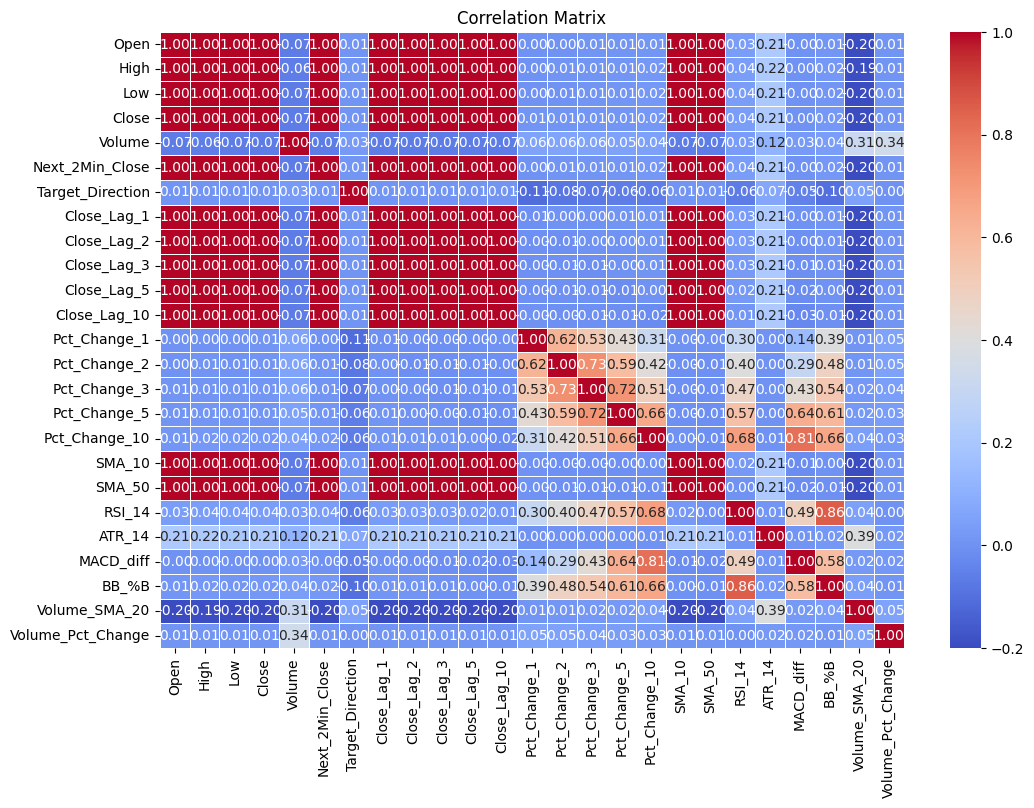

In [49]:
corr_matrix = df_resampled.corr(numeric_only=True)
print(corr_matrix)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [50]:
TARGET = 'Target_Direction'
FEATURES = [col for col in df_model.columns if col not in [TARGET]]

In [51]:
X = df_model[FEATURES]
y = df_model[TARGET]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=False, 
)

In [53]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
print(f"Kích thước Train: {len(X_train_scaled)}")
print(f"Kích thước Test: {len(X_test_scaled)}")

Kích thước Train: 62858
Kích thước Test: 15715


In [55]:
def evaluate_classification(y_true, y_pred, model_name):
    print(f"\n--- Kết quả đánh giá cho {model_name} ---")
    
    # 1. Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy (Độ chính xác): {accuracy * 100:.2f}%")
        
    # 3. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['0 (Giảm)', '1 (Tăng)']))
    
    # 4. Confusion Matrix
    print("Confusion Matrix:")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=['Giảm', 'Tăng'], cmap='Blues')
    plt.show()


--- Kết quả đánh giá cho Logistic Regression ---
Accuracy (Độ chính xác): 61.17%

Classification Report:
              precision    recall  f1-score   support

    0 (Giảm)       0.87      0.54      0.67     11296
    1 (Tăng)       0.40      0.79      0.53      4419

    accuracy                           0.61     15715
   macro avg       0.64      0.67      0.60     15715
weighted avg       0.74      0.61      0.63     15715

Confusion Matrix:


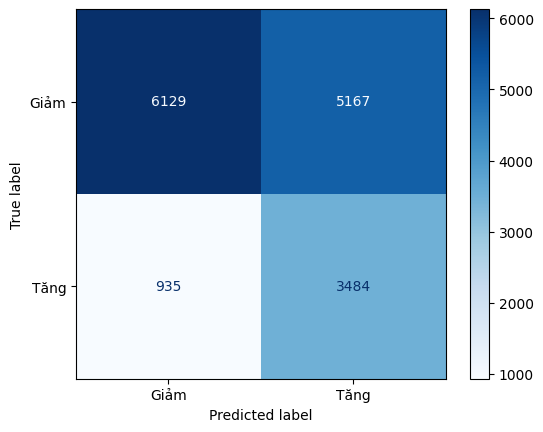

In [56]:
# 1. Khởi tạo mô hình
# (Dùng class_weight='balanced' nếu y_train bị mất cân bằng)
model_logreg = LogisticRegression(
    random_state=42, 
    class_weight='balanced',
    max_iter=1000 # Tăng max_iter để đảm bảo hội tụ
)

# 2. Huấn luyện
model_logreg.fit(X_train_scaled, y_train)

# 3. Dự đoán
y_pred_logreg = model_logreg.predict(X_test_scaled)

# 4. Đánh giá
evaluate_classification(y_test, y_pred_logreg, "Logistic Regression")

Bắt đầu tìm kiếm tham số tốt nhất...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Tham số tốt nhất tìm được: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}

--- Kết quả đánh giá cho Random Forest (Đã tinh chỉnh) ---
Accuracy (Độ chính xác): 71.74%

Classification Report:
              precision    recall  f1-score   support

    0 (Giảm)       0.72      0.98      0.83     11296
    1 (Tăng)       0.47      0.04      0.08      4419

    accuracy                           0.72     15715
   macro avg       0.60      0.51      0.46     15715
weighted avg       0.65      0.72      0.62     15715

Confusion Matrix:


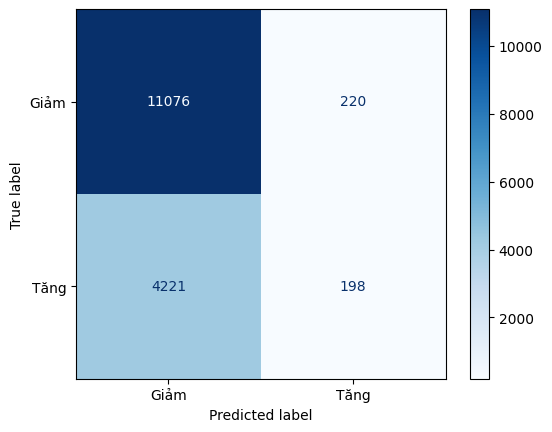

In [57]:
# 1. Định nghĩa lưới tham số (param_grid) để tìm kiếm
# (Đây là một lưới nhỏ để chạy nhanh, bạn có thể thêm nhiều giá trị hơn)
param_grid = {
    'n_estimators': [100, 200],       # Số lượng cây
    'max_depth': [10, 20, None],        # Độ sâu tối đa của cây
    'min_samples_leaf': [1, 5]          # Số mẫu tối thiểu ở mỗi lá
}

# 2. Khởi tạo GridSearchCV
# cv=3: Dùng 3-fold cross-validation (chia tập train làm 3)
# n_jobs=-1: Dùng tất cả CPU để chạy song song
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'), # Dùng class_weight nếu y mất cân bằng
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='accuracy', # Tiêu chí để chọn mô hình tốt nhất
    verbose=2 # In ra tiến trình
)

# 3. Huấn luyện (Tìm kiếm) trên tập train
print("Bắt đầu tìm kiếm tham số tốt nhất...")
grid_search_rf.fit(X_train_scaled, y_train)

# 4. In ra tham số tốt nhất
print(f"\nTham số tốt nhất tìm được: {grid_search_rf.best_params_}")

# 5. Lấy mô hình tốt nhất
best_model_rf = grid_search_rf.best_estimator_

# 6. Dự đoán và Đánh giá
y_pred_rf = best_model_rf.predict(X_test_scaled)
evaluate_classification(y_test, y_pred_rf, "Random Forest (Đã tinh chỉnh)")

In [58]:

from sklearn.utils.class_weight import compute_class_weight

# 1. Tạo chuỗi (Sequences)
TIME_STEPS = 30 
n_features = X_train_scaled.shape[1]

y_train_gen = y_train.values.reshape(-1, 1)
y_test_gen = y_test.values.reshape(-1, 1)

# 2. Xây dựng mô hình LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(TIME_STEPS, n_features), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=25, activation='relu'))
model_lstm.add(Dense(units=1, activation='sigmoid')) 

model_lstm.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
print(model_lstm.summary())

# 3. Tạo các Generators
val_split_index = int(len(X_train_scaled) * 0.8)

# Generator cho tập Huấn luyện (Train)
train_only_generator = TimeseriesGenerator(
    X_train_scaled[:val_split_index], y_train_gen[:val_split_index],
    length=TIME_STEPS, batch_size=32
)
# Generator cho tập Kiểm định (Validation)
validation_generator = TimeseriesGenerator(
    X_train_scaled[val_split_index:], y_train_gen[val_split_index:],
    length=TIME_STEPS, batch_size=32
)
# *** ĐÂY LÀ PHẦN BỊ THIẾU ***
# Generator cho tập Dự đoán (Test) - Dùng ở Ô 10
test_generator = TimeseriesGenerator(
    X_test_scaled, y_test_gen, 
    length=TIME_STEPS, batch_size=1
)
# -----------------------------

# 4. Tính toán trọng số lớp (class weights)
weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), weights)}
print(f"Sử dụng Class Weights: {class_weights_dict}")

# 5. Huấn luyện (ĐÃ THÊM class_weight)
model_lstm.fit(
    train_only_generator,
    validation_data=validation_generator, 
    epochs=30, 
    callbacks=[early_stop],
    verbose=1,
    class_weight=class_weights_dict
)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        15,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,501 (142.58 KB)

 Trainable params: 36,501 (142.58 KB)

 Non-trainable params: 0 (0.00 B)

None
Sử dụng Class Weights: {np.int64(0): np.float64(0.6887642173084088), np.int64(1): np.float64(1.8244035525628375)}
Epoch 1/30


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.5684 - loss: 0.6906 - val_accuracy: 0.7126 - val_loss: 0.6878
Epoch 2/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.5816 - loss: 0.6903 - val_accuracy: 0.7126 - val_loss: 0.6806
Epoch 3/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.5965 - loss: 0.6901 - val_accuracy: 0.6833 - val_loss: 0.6812
Epoch 4/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.5866 - loss: 0.6898 - val_accuracy: 0.7019 - val_loss: 0.6846
Epoch 5/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.5877 - loss: 0.6897 - val_accuracy: 0.6930 - val_loss: 0.6800
Epoch 6/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.5815 - loss: 0.6890 - val_accuracy: 0.5922 - val_loss: 0.6871
Epoch 7/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.5557 - loss: 0.6888 - val_accuracy: 0.6175 - val_loss: 0.6833
Epoch 8/30
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.5571 - loss: 0.68

15685/15685 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step

--- Kết quả đánh giá cho LSTM ---
Accuracy (Độ chính xác): 57.25%

Classification Report:
              precision    recall  f1-score   support

    0 (Giảm)       0.75      0.60      0.67     11273
    1 (Tăng)       0.33      0.50      0.40      4412

    accuracy                           0.57     15685
   macro avg       0.54      0.55      0.53     15685
weighted avg       0.64      0.57      0.59     15685

Confusion Matrix:


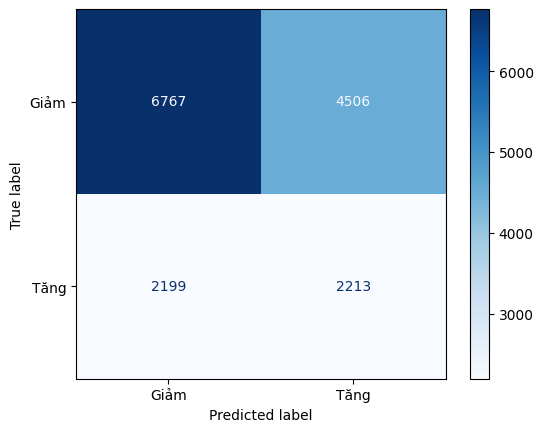

In [59]:
# 1. Lấy y_test thực tế (bị ngắn đi TIME_STEPS)
y_test_actual = y_test_gen[TIME_STEPS:].ravel()

# 2. Dự đoán
y_pred_scaled_lstm = model_lstm.predict(test_generator)

# 3. Chuyển đổi xác suất (> 0.5) thành lớp (0 hoặc 1)
y_pred_lstm = (y_pred_scaled_lstm > 0.5).astype(int)

# 4. Đánh giá
evaluate_classification(y_test_actual, y_pred_lstm, "LSTM")